# Course Recommender System

In [8]:
from collections import defaultdict
from itertools import combinations
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from coursemate.dataset import Dataset

In [9]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Dataset preparation

In [11]:
dataset = Dataset('../data/Coursera_courses.csv', '../data/Coursera.csv', '../data/Coursera_reviews.csv')
dataset.set_interaction_counts(3, 50)
dataset.show_dataset_details()

Loading Coursera courses...
Loading Coursera reviews...
Segmenting out students with less than 3 or more than 50 reviews...
30719 students, 468 courses, 174219 reviews
Sparsity: 1.21%
Duplicates: 4.54%


In [12]:
dataset.set_train_test_split_by_user()

# For the content-based and CF recommender
train_Xmatrix, train_ymatrix, df_train_X, df_train_y = dataset.get_train_matrix_split(ratio=0.8)
test_Xmatrix, test_ymatrix, df_test_X, df_test_y = dataset.get_test_matrix_split(ratio=0.5)

# For the sequential/KB recommender
train_Xseq, test_Xseq, train_yseq, test_yseq = dataset.get_train_test_next_course_predictions()

Setting the train-test split by user...
Computing the training and test rating matrix...


131100it [00:11, 11585.30it/s]


Computing the test rating matrix split...
Computing the training and test rating matrix...


131100it [00:11, 11671.80it/s]
43119it [00:03, 12069.90it/s]


Computing the training and test list of sequences...


131100it [00:09, 14147.42it/s]
43119it [00:03, 13011.04it/s]


In [13]:
print(f"Training: From {len(df_train_X)} ratings, predict the next {len(df_train_y)} for {df_train_y['reviewers'].nunique()} users")
print(f"Testing: From {len(df_test_X)} ratings, predict the next {len(df_test_y)} for {df_test_y['reviewers'].nunique()} users")

Training: From 119949 ratings, predict the next 11151 for 6631 users
Testing: From 157922 ratings, predict the next 16297 for 7680 users


In [14]:
print(f"Training (Sequential): From {len(train_Xseq)} sequences, predict the next course taken for {df_train_y['reviewers'].nunique()} users")
print(f"Testing (Sequential): From {len(test_Xseq)} sequences, predict the next course taken for {df_test_y['reviewers'].nunique()} users")

Training (Sequential): From 108061 sequences, predict the next course taken for 6631 users
Testing (Sequential): From 7680 sequences, predict the next course taken for 7680 users


## 1. Content-Based Recommendation

**Core Idea**

The main idea behind Content-Based Recommendation is that people will prefer similar courses. For example, if you've taken a python course, then a you might prefer another course that also uses python. 

**Problems**

This approach might cause a lack of serendipity and diversity as the recommended course might be too similar to the user profile and/or the other courses recommended.

**Process**
- Pre-processing
    - lower
    - Removal of special characters and stopwords
    - Lemming
- Checking for similarity
- Sort courses based on similarity and select top-k


### 1.1 Hyperparameter tuning

Performing a gridsearch to check for the best parameters

In [56]:
from coursemate.model import ContentBasedModel
from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer
model = ContentBasedModel(course_set=dataset.course_set)

# Parameters
features_list = [50,100,500,1000,5000,10000,50000,100000,500000]
vectors = [TfidfVectorizer, CountVectorizer]
categories = [['skills'], ['skills','description']]
n_users = 500

# Gridsearch
results = model.ContentBasedModel_gridsearch(df_test_X,df_test_y,vectors,n_users,features_list,categories,[5])


Best Configuration:
Vectorizer: TfidfVectorizer
n_features: 5000
Categories: ['skills', 'description']
Hitrate: 0.208


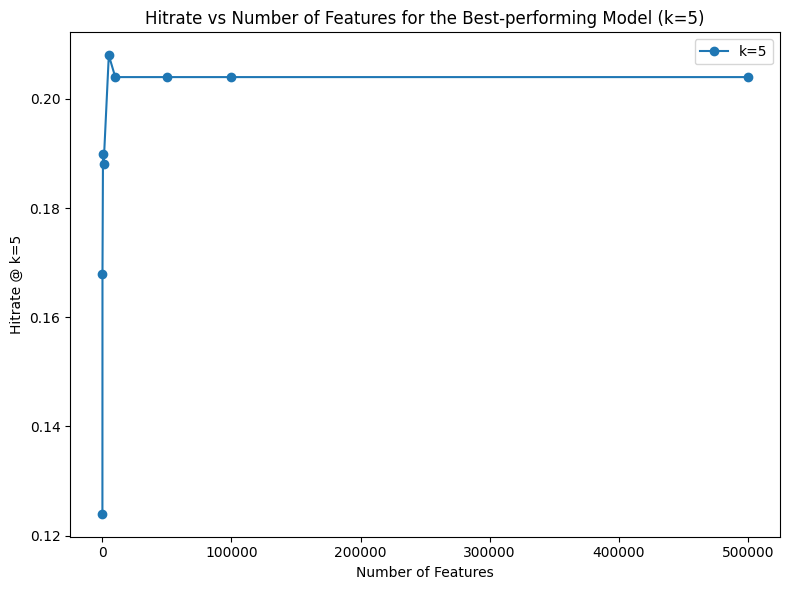

In [111]:
unique_reviewers_y = df_test_y['reviewers'].unique()

def find_best_config(results):
    best_config = None
    max_hitrate = 0.0

    for result in results:
        total_hits = sum(result['hits'].values())
        total_tests = len(result['hits']) * len(unique_reviewers_y)
        hitrate = total_hits / total_tests

        if hitrate > max_hitrate:
            max_hitrate = hitrate
            best_config = result

    return best_config

best_config = find_best_config(results)


# Print the best configuration
if best_config is not None:
    print("Best Configuration:")
    print(f"Vectorizer: {best_config['Vectorizer']}")
    print(f"n_features: {best_config['n_features']}")
    print(f"Categories: {best_config['categories']}")
    print(f"Hitrate: {best_config['hits'][k] / n_users}")
else:
    print("No best configuration found.")


def plot_hitrate_vs_n_features(best_config, k_value):
    plt.figure(figsize=(8, 6))

    vectorizer_name = str(best_config['Vectorizer']).split('.')[-1].replace("'>", "")
    categories = best_config['categories']
    features = []
    hitrates = []
    for i in results:
        if i['Vectorizer'] == vectorizer_name and i['categories'] == categories:
            hitrates.append(i['hits'][k_value]/ n_users)
            features.append(i['n_features'] )

    plt.plot(features,hitrates, label=f'k={k_value}', marker='o')

    plt.xlabel('Number of Features')
    plt.ylabel(f'Hitrate @ k={k_value}')
    plt.title(f'Hitrate vs Number of Features for the Best-performing Model (k={k_value})')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_hitrate_vs_n_features(best_config, 5)

### 1.2 Preprocessing and fitting the vectors

In [117]:
from coursemate.model import ContentBasedModel
from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer
model = ContentBasedModel(course_set=dataset.course_set)

model.preprocess()
model.fit(Vectorizer=TfidfVectorizer, n_features=5000, categories=['skills','description'])

### 1.3 Recommendation

In [118]:
unique_reviewers_X = df_test_X['reviewers'].unique()
unique_reviewers_y = df_test_y['reviewers'].unique()

recommended_courses_df = pd.DataFrame(index=dataset.course_set.index)

sim_matrix = pd.DataFrame()
k_values = [5, 10]
statistics = {k: {'true_positives': 0, 'false_positives': 0, 'false_negatives': 0} for k in k_values}
hits = {k: 0 for k in k_values}
count = 0

for user in unique_reviewers_X:
    if user in unique_reviewers_y:
        count += 1
        user_profile = tuple(df_test_X[df_test_X['reviewers'] == user]['course_id'])
        target = df_test_y[df_test_y['reviewers'] == user]['course_id']

        recommendations = model.recommend(user_profile,None)
        recommendation_ids = [recommendation[0] for recommendation in recommendations]
        
        user_recommendations_df = pd.DataFrame(index=[user], columns=recommendation_ids)

        for course_id, similarity_score in recommendations:
            user_recommendations_df.loc[user, course_id] = similarity_score

        for course_id in user_profile:
            user_recommendations_df.loc[user, course_id] = 1
        
        user_df = pd.DataFrame(index=[user], columns=recommendation_ids)
        for course_id, similarity_score in recommendations:
            user_df.loc[user, course_id] = similarity_score

        for course_id in user_profile:
            user_df.loc[user, course_id] = 1

        sim_matrix = pd.concat([sim_matrix, user_df])

        # Statistics gathering 
        for k in k_values:
            statistics[k]['true_positives'] += len(set(target) & set(recommendation_ids[:k]))
            statistics[k]['false_positives'] += len(set(recommendation_ids[:k]) - set(target))
            statistics[k]['false_negatives'] += len(set(target) - set(recommendation_ids[:k]))
            if len(set(target) & set(recommendation_ids[:k])) > 0:
                hits[k] += 1

# Metric calculation
for k in k_values:
    precision = statistics[k]['true_positives'] / (statistics[k]['true_positives'] + statistics[k]['false_positives']) if (statistics[k]['true_positives'] + statistics[k]['false_positives']) > 0 else 0
    recall = statistics[k]['true_positives'] / (statistics[k]['true_positives'] + statistics[k]['false_negatives']) if (statistics[k]['true_positives'] + statistics[k]['false_negatives']) > 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"For k={k}:")
    print("Precision:", precision)
    print("F1 Score:", f1_score)
    print("Hitrate", hits[k] / count)

sim_matrix.to_csv('content-based-similarity_matrix3.csv')

For k=5:
Precision: 0.042
F1 Score: 0.0621301775147929
Hitrate 0.17
For k=10:
Precision: 0.033
F1 Score: 0.05612244897959184
Hitrate 0.28


In [ ]:
hitrates = {'10':0.068, '100':0.168, '500':0.19, '1000':0.188, 50}
plt.plot(list(hitrates.keys()), list(hitrates.values()))
plt.show()


## 2. Collaborative Filtering Recommendation

## 3. Sequential/Knowledge-Based Recommendation

In [10]:
from coursemate.model import AssociationMiningModel
from coursemate.metrics import (
    calculate_hit_rate_from_next_course_sequences,
    calculate_precision_from_next_course_sequences,
    calculate_f1score_from_next_course_sequences
)

# support cutoff determined empirically, testing the 90th and 99th percentile
model = AssociationMiningModel(cutoff=3, course_set=dataset.course_set)
df_seq = model.get_sequences_data(train_Xseq, train_yseq)
model.fit(df_seq)

100%|██████████| 23039/23039 [00:01<00:00, 12093.84it/s]


1-subsequences: 468
2-subsequences: 90472
3-subsequences: 1835231
(1926171, 2)


In [ ]:
hr5 = calculate_hit_rate_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 5)
hr10 = calculate_hit_rate_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 10)
prec5 = calculate_precision_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 5)
prec10 = calculate_precision_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 10)
f1score5 = calculate_f1score_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 5)
f1score10 = calculate_f1score_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 10)

In [ ]:
print(f"    | Hit rate | Precision | F1 Score")
print(f"@5  | {hr5:.3f}    | {prec5:.3f}     | {f1score5:.3f}   ")
print(f"@10 | {hr10:.3f}    | {prec10:.3f}     | {f1score10:.3f}   ")

    | Hit rate | Precision | F1 Score
@5  | 0.374    | 0.086     | 0.118   
@10 | 0.490    | 0.062     | 0.097   
